In [1]:
#!/usr/bin/env python3
from keras.models import load_model
from keras import backend as K
from keras.losses import mse, binary_crossentropy

from skimage import util
import matplotlib.pyplot as plt
import numpy as np


def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
encoder_fp = "./../models/attpc_enc.h5"
decoder_fp = "./../models/attpc_dec.h5"

encoder = load_model(encoder_fp)
decoder = load_model(decoder_fp)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
import sys 
sys.path.append("/home/solli-comphys/github/VAE-event-classification/src/")

from data_loader import DataLoader

file_location = "/home/solli-comphys/github/VAE-event-classification/data/real/packaged/x-y/proton-carbon-junk-noise.h5"
X_train, y_train, X_test, y_test = DataLoader(file_location)


def rgb2gray(rgb):

    r, g, b = rgb[:, :, :, 0], rgb[:, :, :, 1], rgb[:, :, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


X_train = rgb2gray(X_train)/255
for i, x in enumerate(X_train):
    X_train[i] = util.invert(x)

X_test = rgb2gray(X_test)/255
for i, x in enumerate(X_test):
    X_test[i] = util.invert(x)

threshhold_indices_train = X_train < 1e-2
threshhold_indices_test = X_test < 1e-2

X_train[threshhold_indices_train] = 0
X_test[threshhold_indices_test] = 0

xStd = np.std(X_train[np.nonzero(X_train)])
X_train = X_train/xStd
X_test = X_test/xStd

X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))


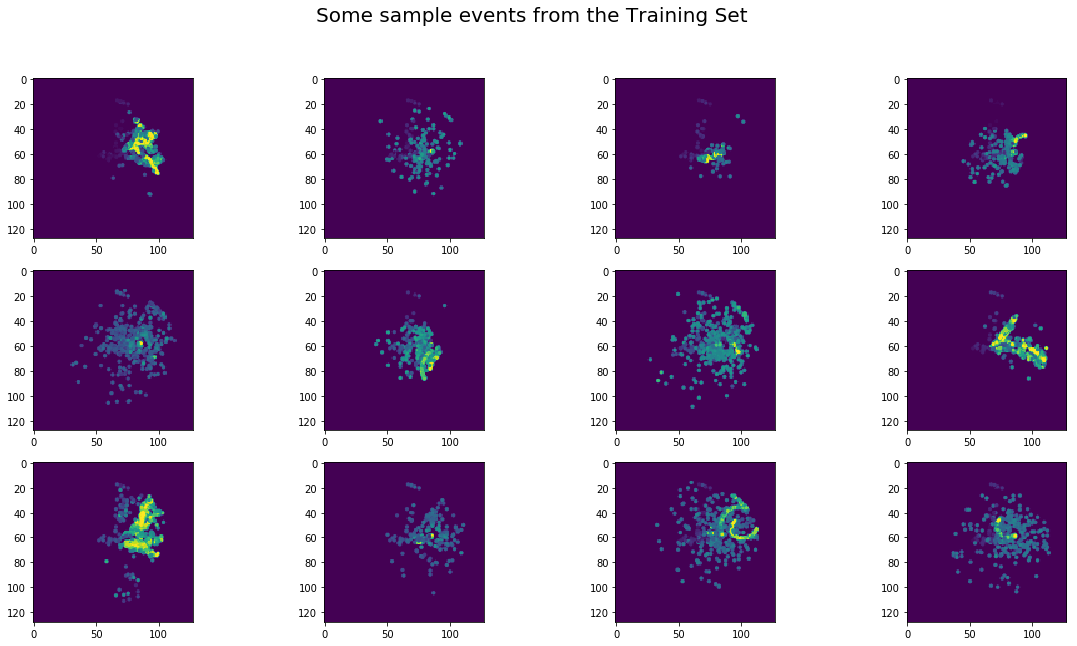

In [4]:
nrows = 3
ncols = 4
n_plots = nrows*ncols

fig, ax = plt.subplots(nrows, ncols, figsize=(20, 10))
which = np.random.choice(np.arange(X_train.shape[0]), size=(n_plots,))
to_plot = X_train[which].reshape(ax.shape + X_train.shape[1:-1])

fig.suptitle("Some sample events from the Training Set", fontsize=20)

for i,row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(to_plot[i,j])

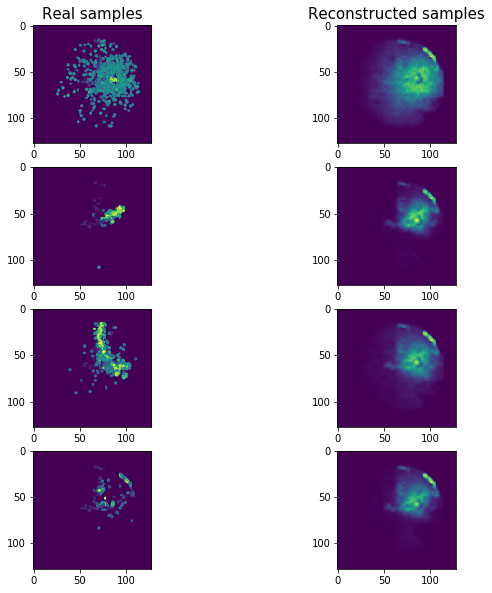

In [5]:
nrows = 4
ncols = 2
n_plots = nrows*ncols

fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))
which = np.random.choice(np.arange(X_train.shape[0]), size=(nrows,))
to_plot = X_train[which].reshape(which.shape + X_train.shape[1:-1])

encoded_samples = encoder.predict(to_plot.reshape(to_plot.shape + (1, )))[2]
decoded_samples = decoder.predict(encoded_samples)
decoded_samples = decoded_samples.reshape(decoded_samples.shape[:-1])

for i, row in enumerate(ax):
    if i == 0:
        row[0].set_title("Real samples", fontsize=15)
        row[1].set_title("Reconstructed samples", fontsize=15)
        
    row[0].imshow(to_plot[i])
    row[1].imshow(decoded_samples[i])

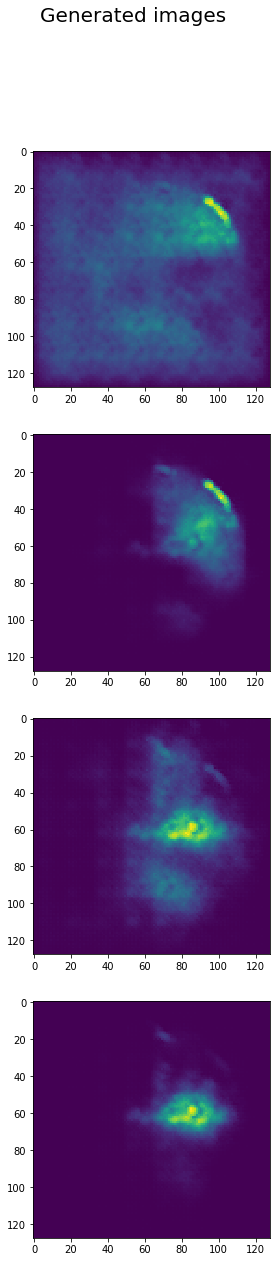

In [6]:
latent_dim = 50
samp = np.random.normal(0, 1, size=(4, latent_dim))
generated_images = decoder.predict(samp)

fig, ax = plt.subplots(4, figsize=(20, 20))
fig.suptitle("Generated images", fontsize=20)

for i, ao in enumerate(ax): 
    ao.imshow(generated_images[i].reshape((128, 128)))